# Gan Training Experiments

Este notebook fue utilizado para correr los experimentos de definición de técnicas de entrenamiento y de arquitectura de la GAN utilizada en la memoria.

In [1]:
import sys
from pathlib import Path

# Agregar la carpeta src al Path para poder cargar los métodos y clases necesarias.
# También agregamos la carpeta data.
src_path = str(Path.cwd().parents[0] / "src")

if src_path not in sys.path:
    sys.path.append(src_path)    

## Cargar Librerías

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [4]:
from keras.models import Model, load_model
from keras import backend as K

Using TensorFlow backend.


## Cargar métodos y clases necesarias

In [5]:
from utils.data import(
    read_space_lens_images,
    read_space_no_lens_images,
    read_space_based_lens_in_chunks
)

from gan_models import (
    LensGenV1
)

## Cargar dataset

Se carga el dataset de entrenamiento. En particular se cargan en memoria todas las imágenes con evidencias de lentes de la categoría Space Based del challenge de detección de lentes.

Como el dataset se encuentra en formato FITS, se cargan dichos archivos, se transforman en arreglos de numpy para luego ser almacenados en disco. De esta manera no es necesario volver a realizar dicha transformación cada vez.

In [6]:
df_space = pd.read_csv(
    '../data/space_based_data/SpaceBasedTraining/classifications.csv',
    sep=','
)
df_space = df_space.astype({'ID':int})

try:
    dict_data = np.load('../data/space_based_data/space_lens_images.npz')
    # extract the first array
    lens_images = dict_data['arr_0']
except:
    path_space_based = '../data/space_based_data/SpaceBasedTraining/Public/Band1/'
    lens_images = read_space_lens_images(
        path_space_based,
        df_space,
        lens_label=1
    )
    np.savez_compressed('../data/space_based_data/space_lens_images.npz', lens_images)

# DCGAN

La GAN a utilizar es una Deep Generative Adversarial Network (DCGAN), la cual es el resultado de una exploración de arquitecturas buscando estabilizar el entrenamiento de una GAN al intentar escalarla al uso de capas convolucionales.

Esta GAN sigue los principios de la DCGAN
- Usa convoluciones con stride (normal o transpuesta) para hace reducir/aumentar las dimensiones de la imagen.
- Utiliza BatchNormalization tanto en discriminador como generador, menos en la última capa del generador y la primera del discriminador.
- Utiliza ReLU como activación para el generador, con TanH para la capa de salida.
- Utiliza LeakyReLU para el discriminador, salvo la última capa que utiliza activación sigmoidal.
- No utiliza capa densas.

## Inicialización 

In [7]:
lensgen = LensGenV1(
    latent_dim = 100,
    input_shape=(101,101,1),
    g_initial_filters=128,
    d_initial_filters=32,
    d_params=[(64,1),(128,1),(256,1)],
    g_params=[(128,2),(64,2),(32,2)],
    dataset='lens',
    lr=0.00009
)

initial_dim: 12 n_block: 3
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 101, 101, 1)       2482785   
_________________________________________________________________
model_1 (Model)              (None, 1)                 432897    
Total params: 2,915,682
Trainable params: 2,482,337
Non-trainable params: 433,345
_________________________________________________________________


## Arquitecturas

In [8]:
lensgen.g_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 18432)             1861632   
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 18432)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 12, 12, 128)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 13, 13, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 26, 26, 128)       262272    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 26, 26, 128)       1475

In [10]:
lensgen.d_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 101, 101, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 101, 101, 32)      320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 101, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 51, 51, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 51, 51, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       7385

## Entrenamiento

Entrenamiento del modelo durante 50 epochs. Durante la experimentación se utilizó la misma celda de código, por lo que esto es solo una muestra.

c:\mauro\titulo\codigo_memoria\env\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\mauro\titulo\codigo_memoria\env\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




                    Loss Synthetic: 0.26100000739097595 - Loss Real: 0.26339998841285706 

                    Acc Synthetic: 1.0 - Acc Real: 1.0
                             Generator Acc: 0.0
            

            Epoch: 1 - Discriminator loss:0.2622067928314209 - Discriminator Accuracy: 1.0 - Generator loss:2.155207395553589
            




                    Loss Synthetic: 1.1039999723434448 - Loss Real: 0.745199978351593 

                    Acc Synthetic: 0.33329999446868896 - Acc Real: 0.6000000238418579
                             Generator Acc: 0.06669999659061432
            

            Epoch: 2 - Discriminator loss:0.9246416687965393 - Discriminator Accuracy: 0.46666669845581055 - Generator loss:1.6186559200286865
            




                    Loss Synthetic: 0.7674999833106995 - Loss Real: 0.7128000259399414 

                    Acc Synthetic: 0.53329998254776 - Acc Real: 0.6000000238418579
                             Generator Acc: 0.06669999659061432
            

            Epoch: 3 - Discriminator loss:0.7401516437530518 - Discriminator Accuracy: 0.5666667222976685 - Generator loss:1.6188220977783203
            




                    Loss Synthetic: 0.7470999956130981 - Loss Real: 0.8248999714851379 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.4000000059604645
                             Generator Acc: 0.26669999957084656
            

            Epoch: 4 - Discriminator loss:0.7860066890716553 - Discriminator Accuracy: 0.4333333373069763 - Generator loss:1.2307523488998413
            




                    Loss Synthetic: 0.8151999711990356 - Loss Real: 1.007200002670288 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.13330000638961792
            

            Epoch: 5 - Discriminator loss:0.911213219165802 - Discriminator Accuracy: 0.3333333432674408 - Generator loss:1.3801608085632324
            


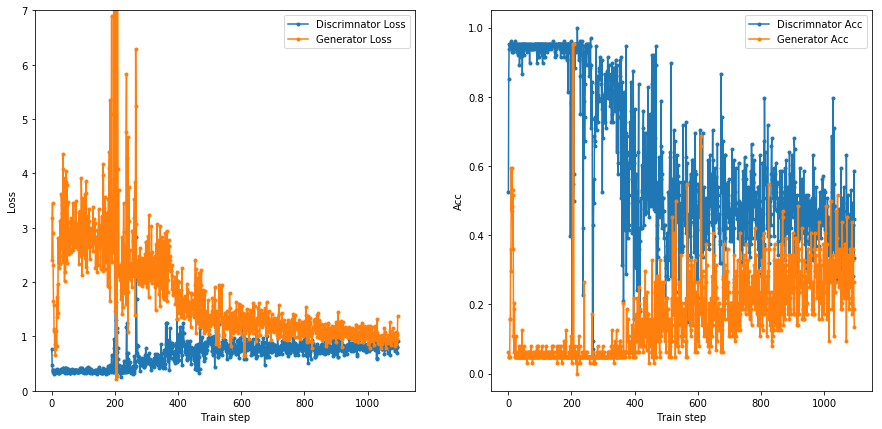

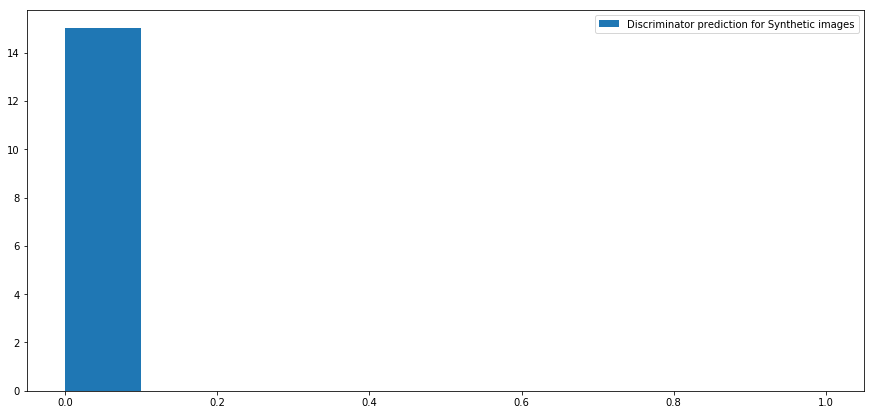

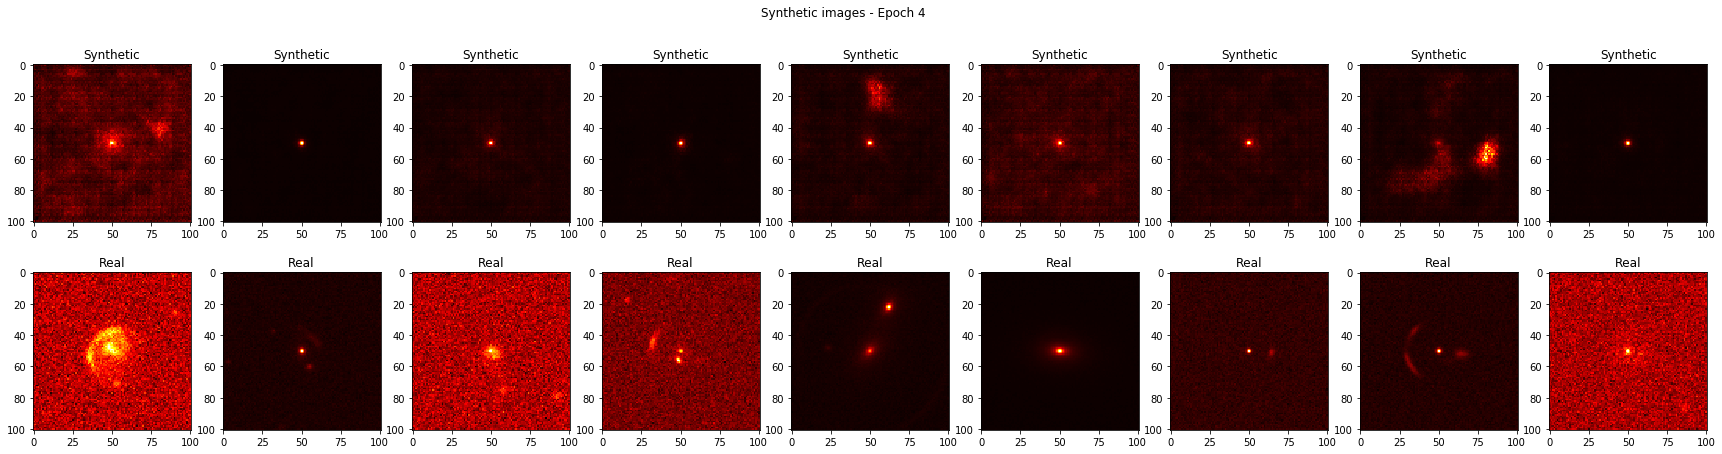



                    Loss Synthetic: 1.0565999746322632 - Loss Real: 0.972599983215332 

                    Acc Synthetic: 0.13330000638961792 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.33329999446868896
            

            Epoch: 6 - Discriminator loss:1.0146316289901733 - Discriminator Accuracy: 0.1666666716337204 - Generator loss:1.0596141815185547
            




                    Loss Synthetic: 0.7487999796867371 - Loss Real: 0.7042999863624573 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.6000000238418579
                             Generator Acc: 0.4000000059604645
            

            Epoch: 7 - Discriminator loss:0.7265576720237732 - Discriminator Accuracy: 0.5333333611488342 - Generator loss:0.8468285799026489
            




                    Loss Synthetic: 0.8644000291824341 - Loss Real: 1.0009000301361084 

                    Acc Synthetic: 0.26669999957084656 - Acc Real: 0.4000000059604645
                             Generator Acc: 0.06669999659061432
            

            Epoch: 8 - Discriminator loss:0.9326627254486084 - Discriminator Accuracy: 0.3333333432674408 - Generator loss:1.2452479600906372
            




                    Loss Synthetic: 0.871399998664856 - Loss Real: 1.1933000087738037 

                    Acc Synthetic: 0.26669999957084656 - Acc Real: 0.13330000638961792
                             Generator Acc: 0.0
            

            Epoch: 9 - Discriminator loss:1.0323739051818848 - Discriminator Accuracy: 0.20000001788139343 - Generator loss:1.391930341720581
            




                    Loss Synthetic: 1.0139000415802002 - Loss Real: 1.2698999643325806 

                    Acc Synthetic: 0.20000000298023224 - Acc Real: 0.0
                             Generator Acc: 0.06669999659061432
            

            Epoch: 10 - Discriminator loss:1.1418662071228027 - Discriminator Accuracy: 0.10000000149011612 - Generator loss:1.3541778326034546
            


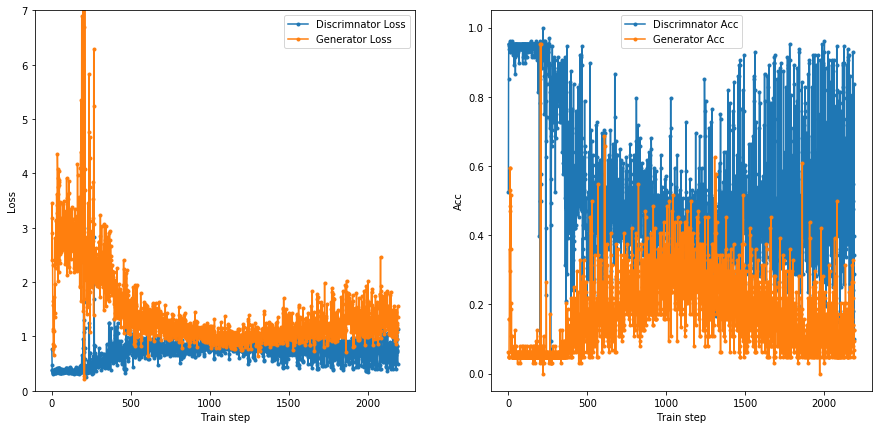

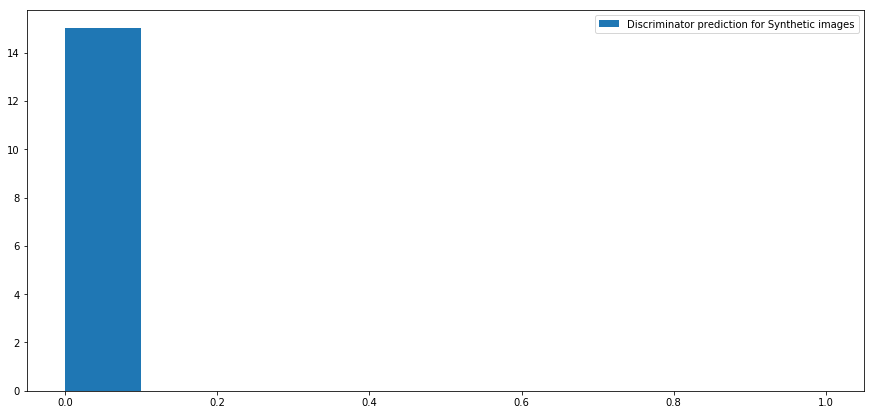

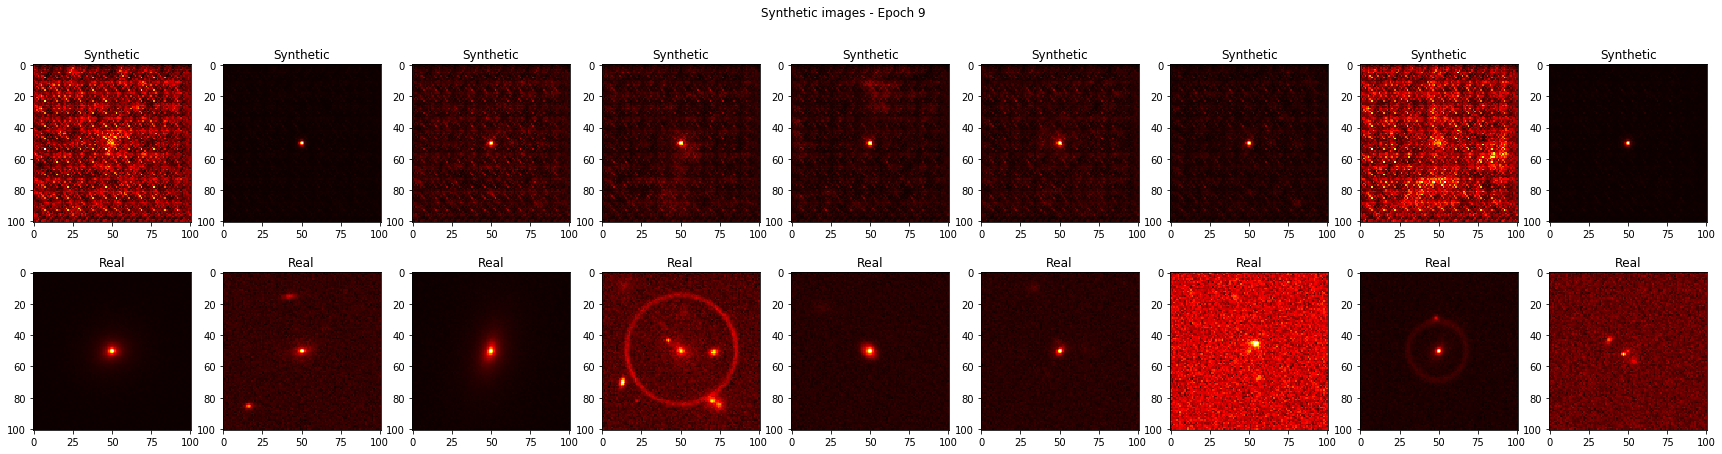



                    Loss Synthetic: 0.7975999712944031 - Loss Real: 1.2556999921798706 

                    Acc Synthetic: 0.26669999957084656 - Acc Real: 0.06669999659061432
                             Generator Acc: 0.06669999659061432
            

            Epoch: 11 - Discriminator loss:1.0266008377075195 - Discriminator Accuracy: 0.1666666716337204 - Generator loss:1.0085179805755615
            




                    Loss Synthetic: 0.6237000226974487 - Loss Real: 1.1796000003814697 

                    Acc Synthetic: 0.666700005531311 - Acc Real: 0.0
                             Generator Acc: 0.4000000059604645
            

            Epoch: 12 - Discriminator loss:0.9016529321670532 - Discriminator Accuracy: 0.3333333432674408 - Generator loss:0.8101083636283875
            




                    Loss Synthetic: 0.7815999984741211 - Loss Real: 1.3401999473571777 

                    Acc Synthetic: 0.4000000059604645 - Acc Real: 0.06669999659061432
                             Generator Acc: 0.13330000638961792
            

            Epoch: 13 - Discriminator loss:1.060916543006897 - Discriminator Accuracy: 0.23333333432674408 - Generator loss:1.1241317987442017
            




                    Loss Synthetic: 0.7128000259399414 - Loss Real: 1.2369999885559082 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.06669999659061432
                             Generator Acc: 0.13330000638961792
            

            Epoch: 14 - Discriminator loss:0.9748699069023132 - Discriminator Accuracy: 0.2666666805744171 - Generator loss:1.270226001739502
            




                    Loss Synthetic: 0.6796000003814697 - Loss Real: 0.8859000205993652 

                    Acc Synthetic: 0.666700005531311 - Acc Real: 0.4666999876499176
                             Generator Acc: 0.06669999659061432
            

            Epoch: 15 - Discriminator loss:0.7827064394950867 - Discriminator Accuracy: 0.5666666626930237 - Generator loss:1.2672375440597534
            


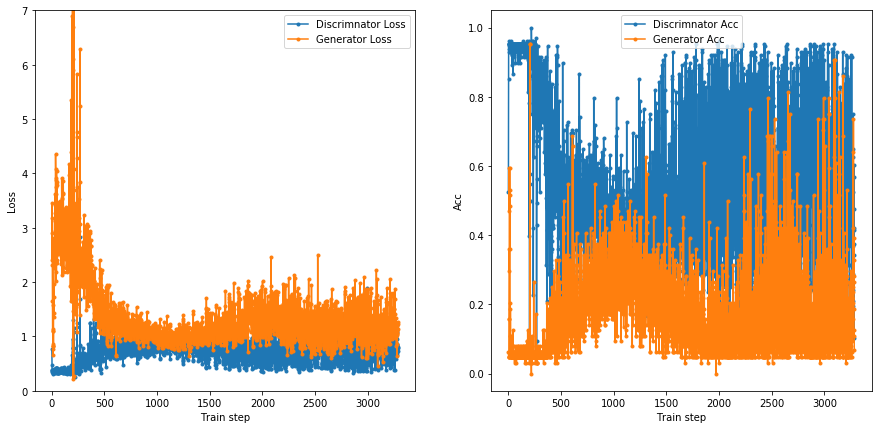

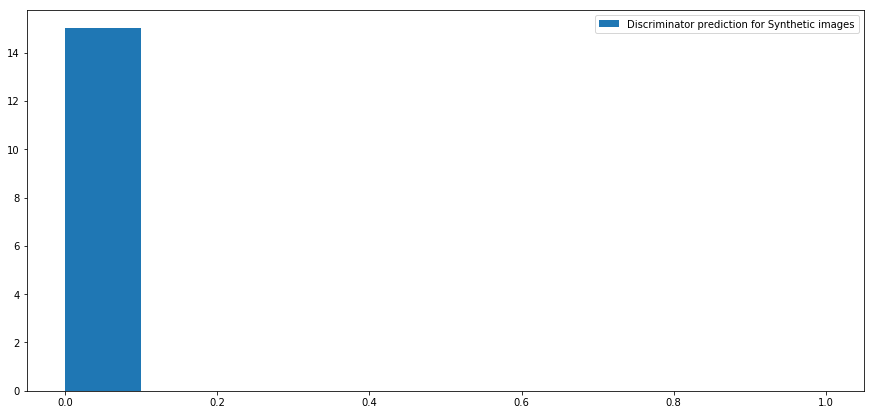

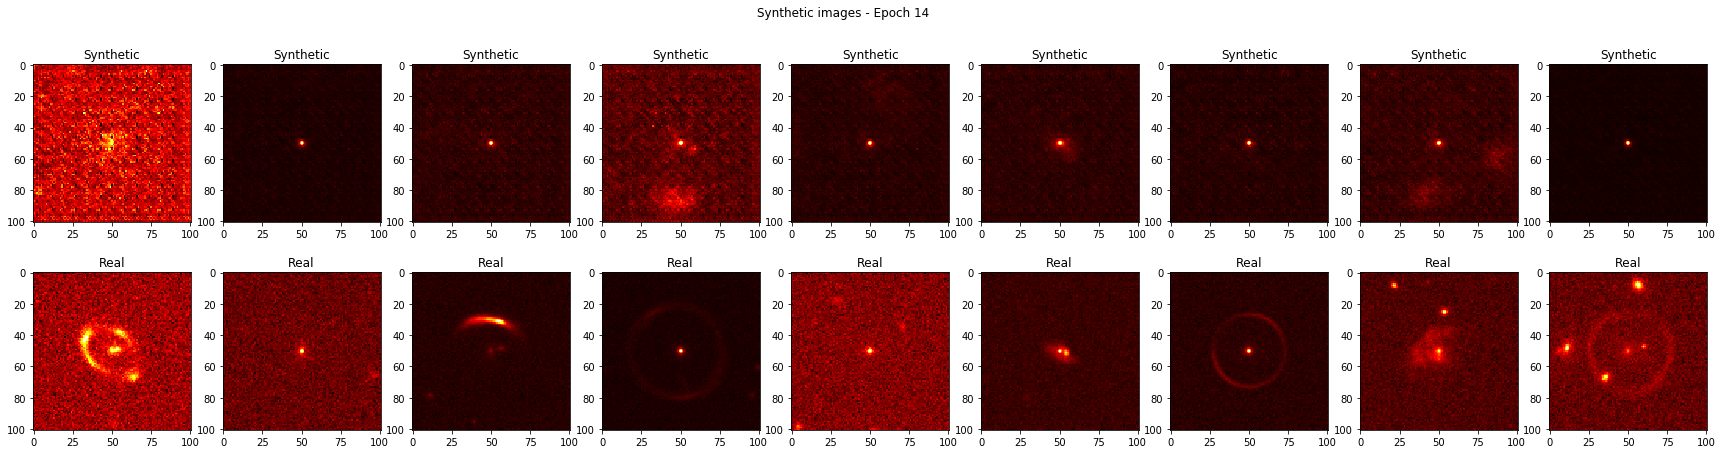



                    Loss Synthetic: 0.7228999733924866 - Loss Real: 1.1597000360488892 

                    Acc Synthetic: 0.53329998254776 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.0
            

            Epoch: 16 - Discriminator loss:0.9413058161735535 - Discriminator Accuracy: 0.36666667461395264 - Generator loss:1.2556437253952026
            




                    Loss Synthetic: 0.8598999977111816 - Loss Real: 1.155500054359436 

                    Acc Synthetic: 0.4000000059604645 - Acc Real: 0.0
                             Generator Acc: 0.06669999659061432
            

            Epoch: 17 - Discriminator loss:1.007660984992981 - Discriminator Accuracy: 0.20000000298023224 - Generator loss:1.482330560684204
            




                    Loss Synthetic: 1.0085999965667725 - Loss Real: 0.8263000249862671 

                    Acc Synthetic: 0.06669999659061432 - Acc Real: 0.4000000059604645
                             Generator Acc: 0.4000000059604645
            

            Epoch: 18 - Discriminator loss:0.9174678325653076 - Discriminator Accuracy: 0.23333333432674408 - Generator loss:0.8593829870223999
            




                    Loss Synthetic: 0.9510999917984009 - Loss Real: 1.4772000312805176 

                    Acc Synthetic: 0.26669999957084656 - Acc Real: 0.06669999659061432
                             Generator Acc: 0.06669999659061432
            

            Epoch: 19 - Discriminator loss:1.2141141891479492 - Discriminator Accuracy: 0.1666666716337204 - Generator loss:1.1761176586151123
            




                    Loss Synthetic: 0.6527000069618225 - Loss Real: 0.8945000171661377 

                    Acc Synthetic: 0.6000000238418579 - Acc Real: 0.33329999446868896
                             Generator Acc: 0.20000000298023224
            

            Epoch: 20 - Discriminator loss:0.7736014127731323 - Discriminator Accuracy: 0.46666669845581055 - Generator loss:1.2262458801269531
            


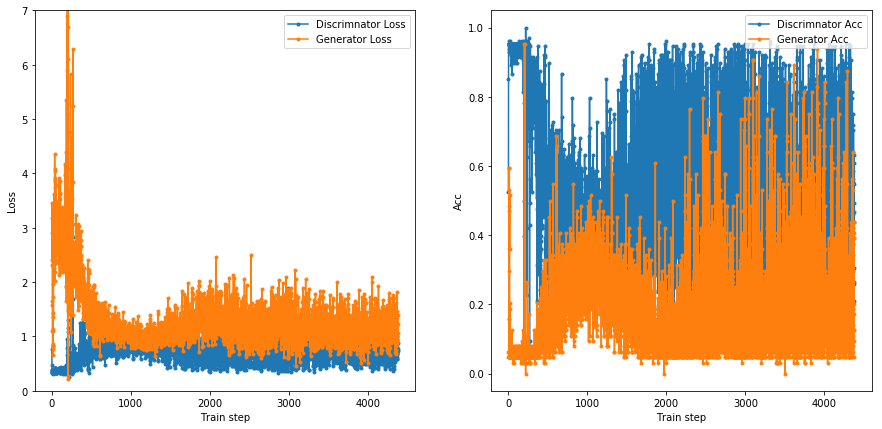

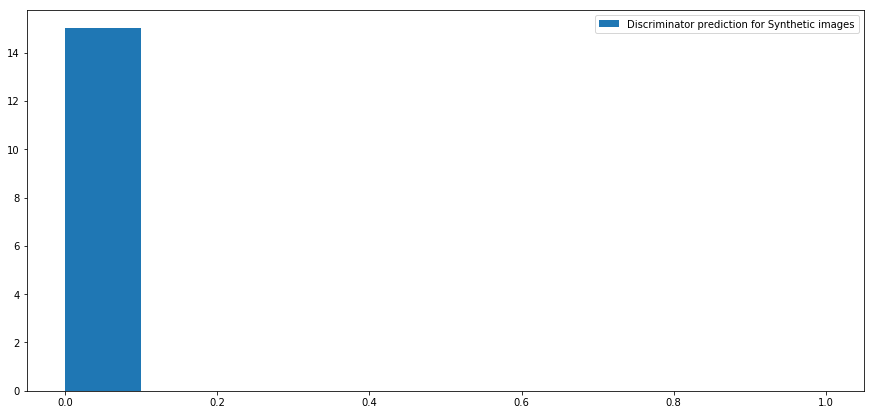

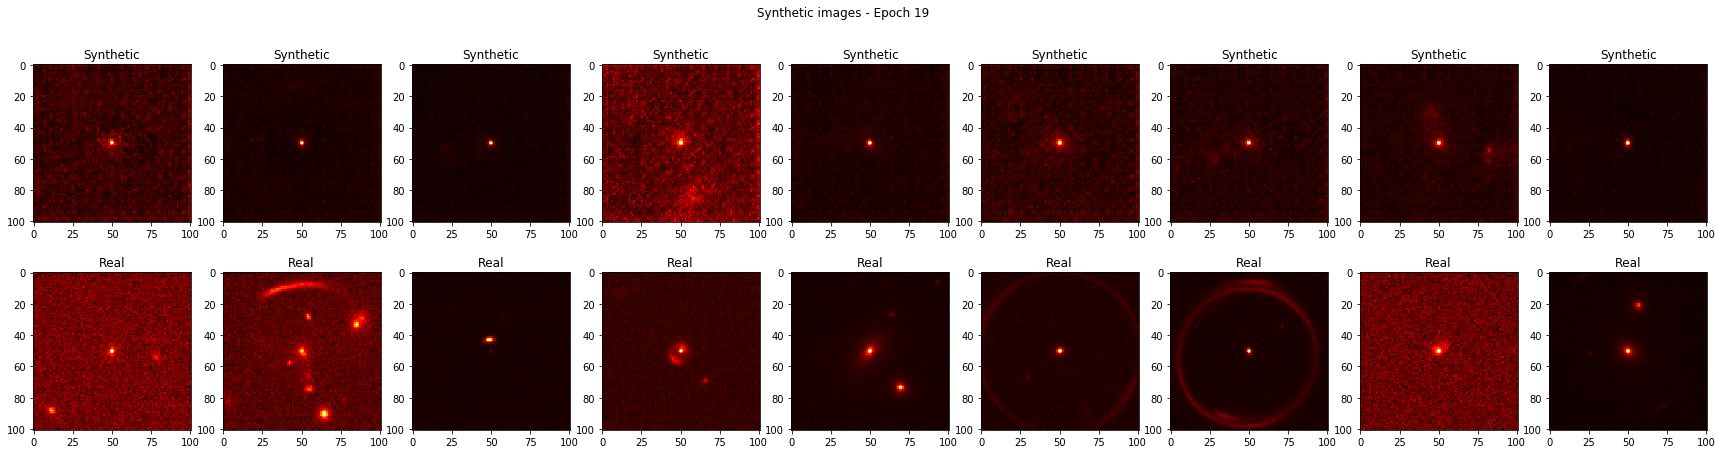



                    Loss Synthetic: 0.6636000275611877 - Loss Real: 0.7958999872207642 

                    Acc Synthetic: 0.733299970626831 - Acc Real: 0.4666999876499176
                             Generator Acc: 0.0
            

            Epoch: 21 - Discriminator loss:0.7297502756118774 - Discriminator Accuracy: 0.6000000238418579 - Generator loss:1.387381672859192
            




                    Loss Synthetic: 0.7297999858856201 - Loss Real: 0.9376000165939331 

                    Acc Synthetic: 0.4000000059604645 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.06669999659061432
            

            Epoch: 22 - Discriminator loss:0.8337185382843018 - Discriminator Accuracy: 0.30000001192092896 - Generator loss:1.1505005359649658
            




                    Loss Synthetic: 0.8359000086784363 - Loss Real: 1.142799973487854 

                    Acc Synthetic: 0.20000000298023224 - Acc Real: 0.13330000638961792
                             Generator Acc: 0.13330000638961792
            

            Epoch: 23 - Discriminator loss:0.9893503189086914 - Discriminator Accuracy: 0.1666666716337204 - Generator loss:1.0605508089065552
            




                    Loss Synthetic: 0.6901000142097473 - Loss Real: 0.9743000268936157 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.13330000638961792
                             Generator Acc: 0.06669999659061432
            

            Epoch: 24 - Discriminator loss:0.8322370052337646 - Discriminator Accuracy: 0.30000001192092896 - Generator loss:1.5518313646316528
            




                    Loss Synthetic: 0.9171000123023987 - Loss Real: 1.0290000438690186 

                    Acc Synthetic: 0.20000000298023224 - Acc Real: 0.06669999659061432
                             Generator Acc: 0.13330000638961792
            

            Epoch: 25 - Discriminator loss:0.9730263948440552 - Discriminator Accuracy: 0.13333334028720856 - Generator loss:1.2165818214416504
            


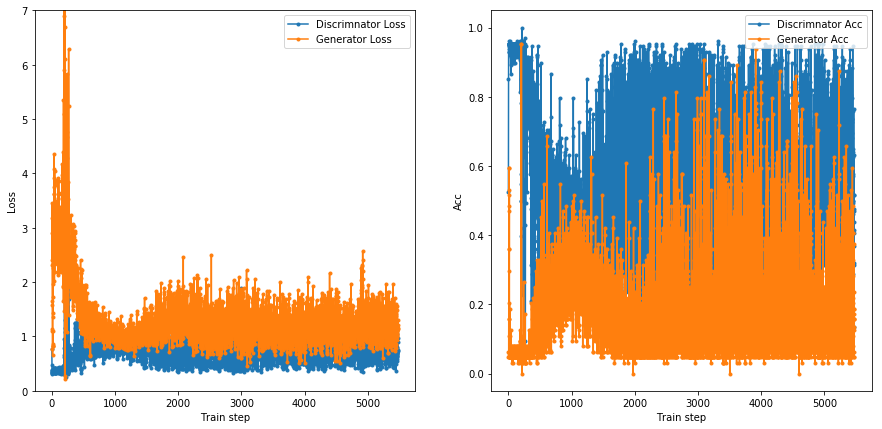

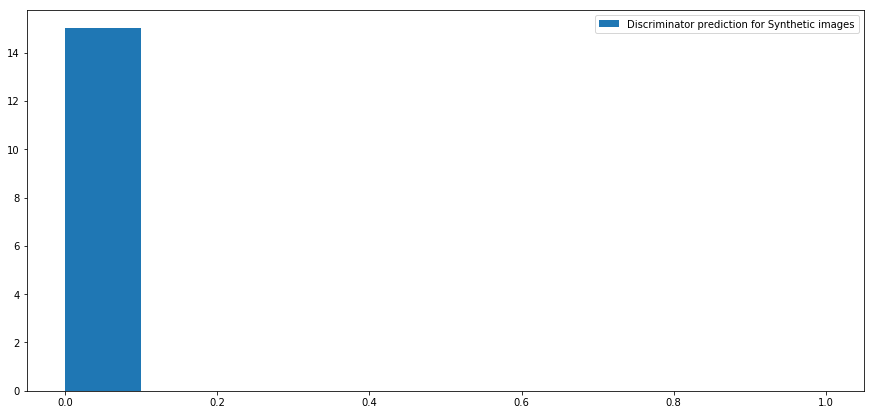

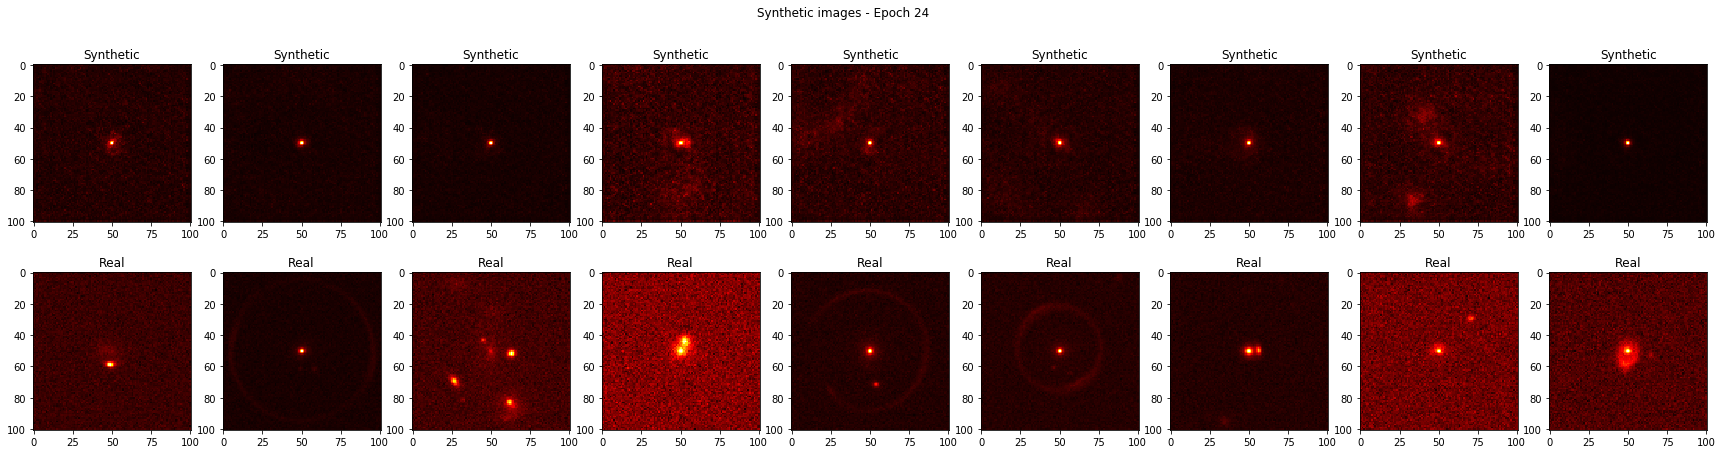



                    Loss Synthetic: 0.7232000231742859 - Loss Real: 1.1160999536514282 

                    Acc Synthetic: 0.53329998254776 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.26669999957084656
            

            Epoch: 26 - Discriminator loss:0.9196757674217224 - Discriminator Accuracy: 0.36666667461395264 - Generator loss:1.0918446779251099
            




                    Loss Synthetic: 0.9186999797821045 - Loss Real: 0.6902999877929688 

                    Acc Synthetic: 0.13330000638961792 - Acc Real: 0.53329998254776
                             Generator Acc: 0.0
            

            Epoch: 27 - Discriminator loss:0.8044832944869995 - Discriminator Accuracy: 0.3333333432674408 - Generator loss:1.4038493633270264
            




                    Loss Synthetic: 0.7152000069618225 - Loss Real: 0.7537000179290771 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.4000000059604645
                             Generator Acc: 0.13330000638961792
            

            Epoch: 28 - Discriminator loss:0.7344439029693604 - Discriminator Accuracy: 0.4333333373069763 - Generator loss:1.166419506072998
            




                    Loss Synthetic: 0.7005000114440918 - Loss Real: 0.9560999870300293 

                    Acc Synthetic: 0.53329998254776 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.0
            

            Epoch: 29 - Discriminator loss:0.8283312320709229 - Discriminator Accuracy: 0.36666667461395264 - Generator loss:1.2010358572006226
            




                    Loss Synthetic: 0.8083000183105469 - Loss Real: 1.2509000301361084 

                    Acc Synthetic: 0.26669999957084656 - Acc Real: 0.06669999659061432
                             Generator Acc: 0.13330000638961792
            

            Epoch: 30 - Discriminator loss:1.0295710563659668 - Discriminator Accuracy: 0.1666666716337204 - Generator loss:0.9554786682128906
            


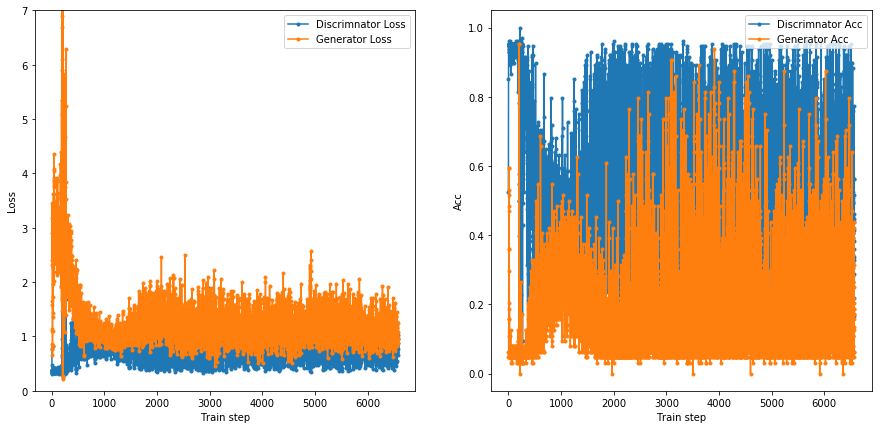

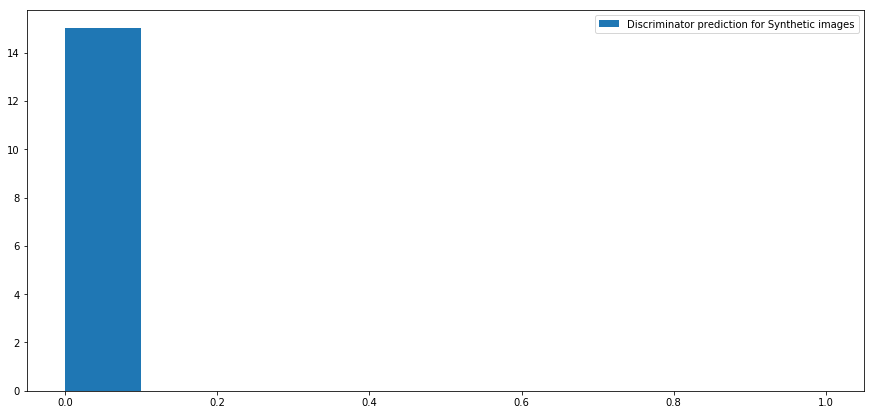

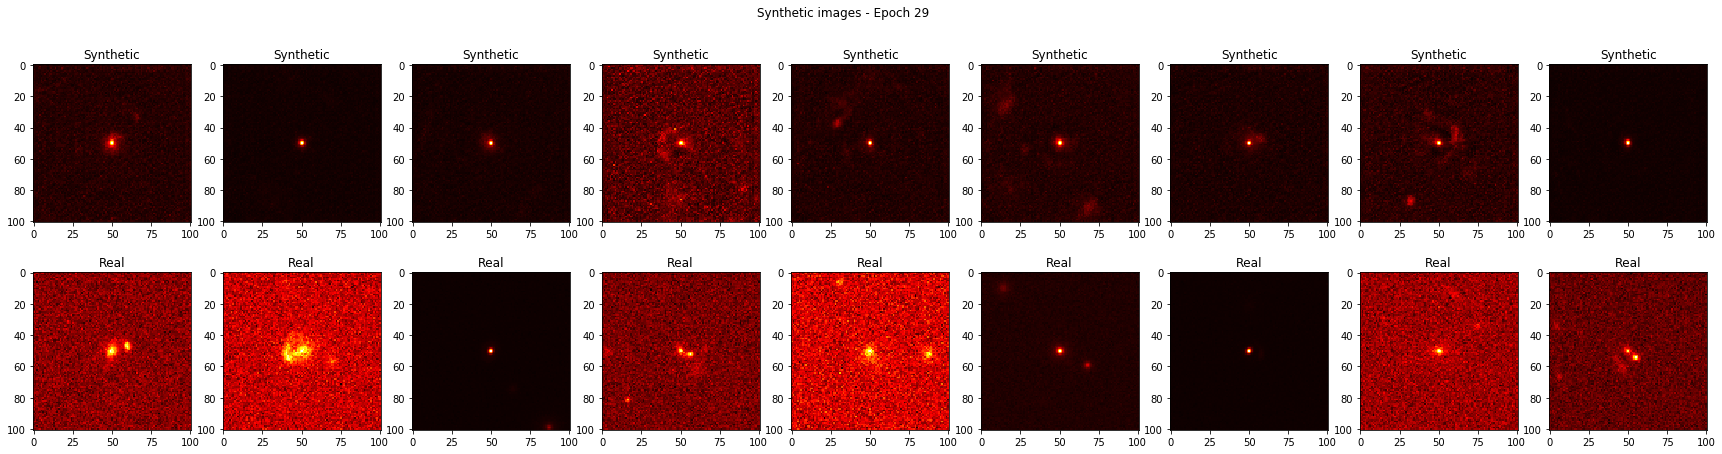



                    Loss Synthetic: 0.7541999816894531 - Loss Real: 1.0901999473571777 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.13330000638961792
            

            Epoch: 31 - Discriminator loss:0.9222384691238403 - Discriminator Accuracy: 0.3333333432674408 - Generator loss:1.3306424617767334
            




                    Loss Synthetic: 1.0226999521255493 - Loss Real: 1.0505000352859497 

                    Acc Synthetic: 0.20000000298023224 - Acc Real: 0.26669999957084656
                             Generator Acc: 0.06669999659061432
            

            Epoch: 32 - Discriminator loss:1.0366196632385254 - Discriminator Accuracy: 0.23333334922790527 - Generator loss:1.0658361911773682
            




                    Loss Synthetic: 0.8101000189781189 - Loss Real: 0.7512000203132629 

                    Acc Synthetic: 0.33329999446868896 - Acc Real: 0.4000000059604645
                             Generator Acc: 0.0
            

            Epoch: 33 - Discriminator loss:0.7806355953216553 - Discriminator Accuracy: 0.36666667461395264 - Generator loss:1.4616014957427979
            




                    Loss Synthetic: 0.6635000109672546 - Loss Real: 0.8526999950408936 

                    Acc Synthetic: 0.666700005531311 - Acc Real: 0.6000000238418579
                             Generator Acc: 0.0
            

            Epoch: 34 - Discriminator loss:0.7581202983856201 - Discriminator Accuracy: 0.6333333253860474 - Generator loss:1.4998692274093628
            




                    Loss Synthetic: 0.5921000242233276 - Loss Real: 0.7348999977111816 

                    Acc Synthetic: 0.733299970626831 - Acc Real: 0.53329998254776
                             Generator Acc: 0.06669999659061432
            

            Epoch: 35 - Discriminator loss:0.6634946465492249 - Discriminator Accuracy: 0.6333333253860474 - Generator loss:1.0670338869094849
            


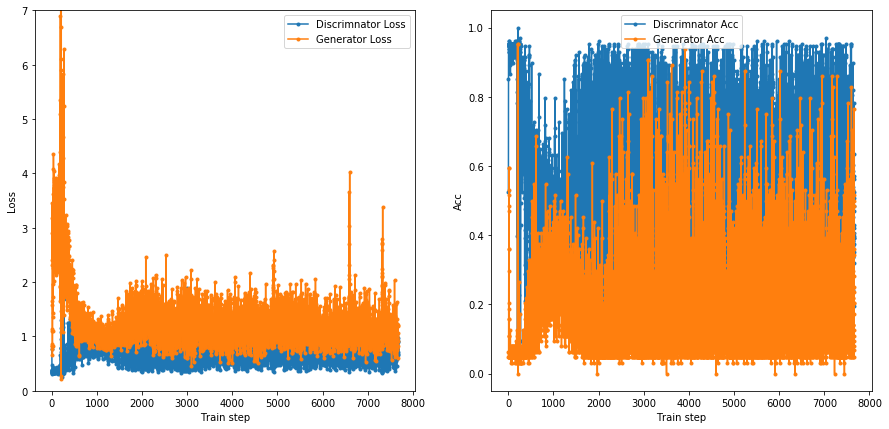

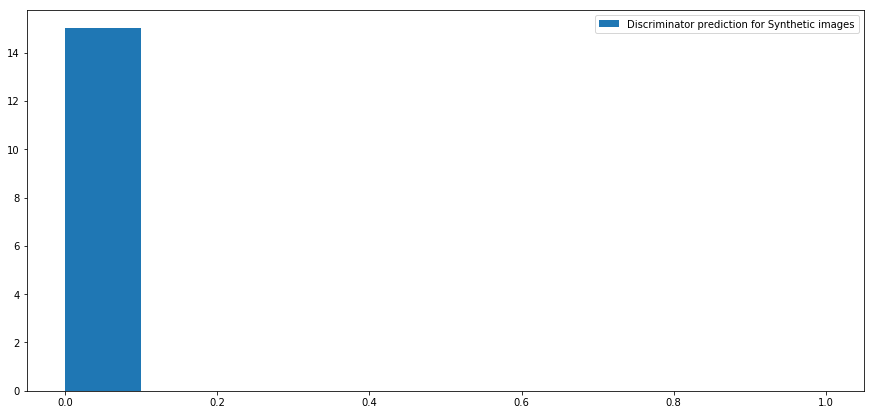

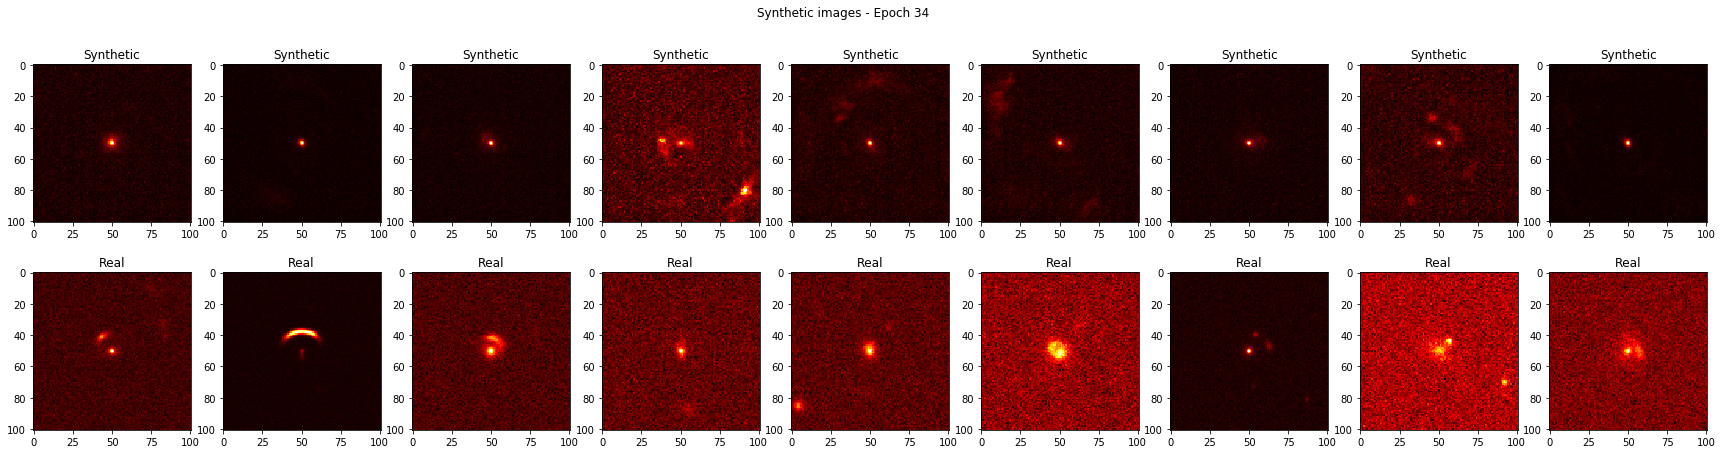



                    Loss Synthetic: 0.795199990272522 - Loss Real: 0.808899998664856 

                    Acc Synthetic: 0.20000000298023224 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.13330000638961792
            

            Epoch: 36 - Discriminator loss:0.8020542860031128 - Discriminator Accuracy: 0.20000000298023224 - Generator loss:1.1628777980804443
            




                    Loss Synthetic: 0.7336999773979187 - Loss Real: 0.8934000134468079 

                    Acc Synthetic: 0.4000000059604645 - Acc Real: 0.33329999446868896
                             Generator Acc: 0.26669999957084656
            

            Epoch: 37 - Discriminator loss:0.8135650157928467 - Discriminator Accuracy: 0.36666667461395264 - Generator loss:0.9698095917701721
            




                    Loss Synthetic: 0.833899974822998 - Loss Real: 0.8197000026702881 

                    Acc Synthetic: 0.33329999446868896 - Acc Real: 0.26669999957084656
                             Generator Acc: 0.0
            

            Epoch: 38 - Discriminator loss:0.8268398642539978 - Discriminator Accuracy: 0.30000001192092896 - Generator loss:1.2308127880096436
            




                    Loss Synthetic: 0.7003999948501587 - Loss Real: 0.9235000014305115 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.26669999957084656
                             Generator Acc: 0.733299970626831
            

            Epoch: 39 - Discriminator loss:0.81195068359375 - Discriminator Accuracy: 0.36666667461395264 - Generator loss:0.6321097016334534
            




                    Loss Synthetic: 0.5748000144958496 - Loss Real: 1.0787999629974365 

                    Acc Synthetic: 0.8666999936103821 - Acc Real: 0.26669999957084656
                             Generator Acc: 0.0
            

            Epoch: 40 - Discriminator loss:0.826819658279419 - Discriminator Accuracy: 0.5666666626930237 - Generator loss:1.4331458806991577
            


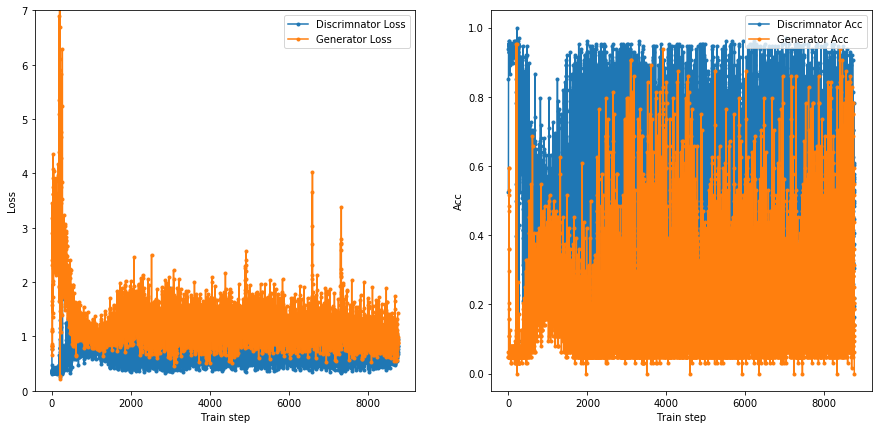

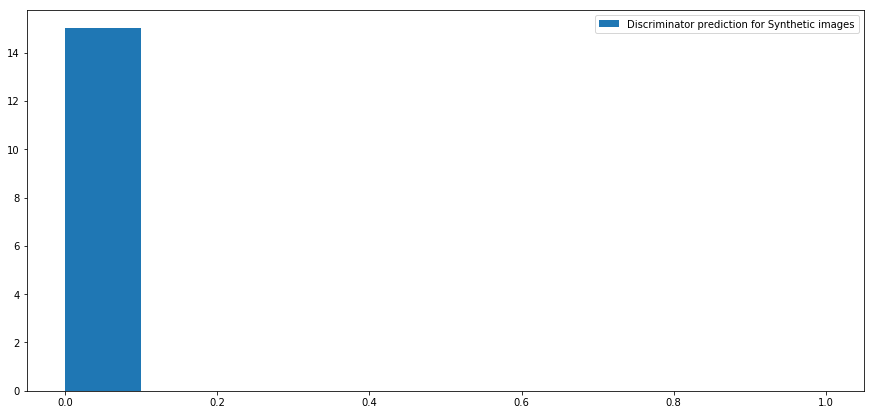

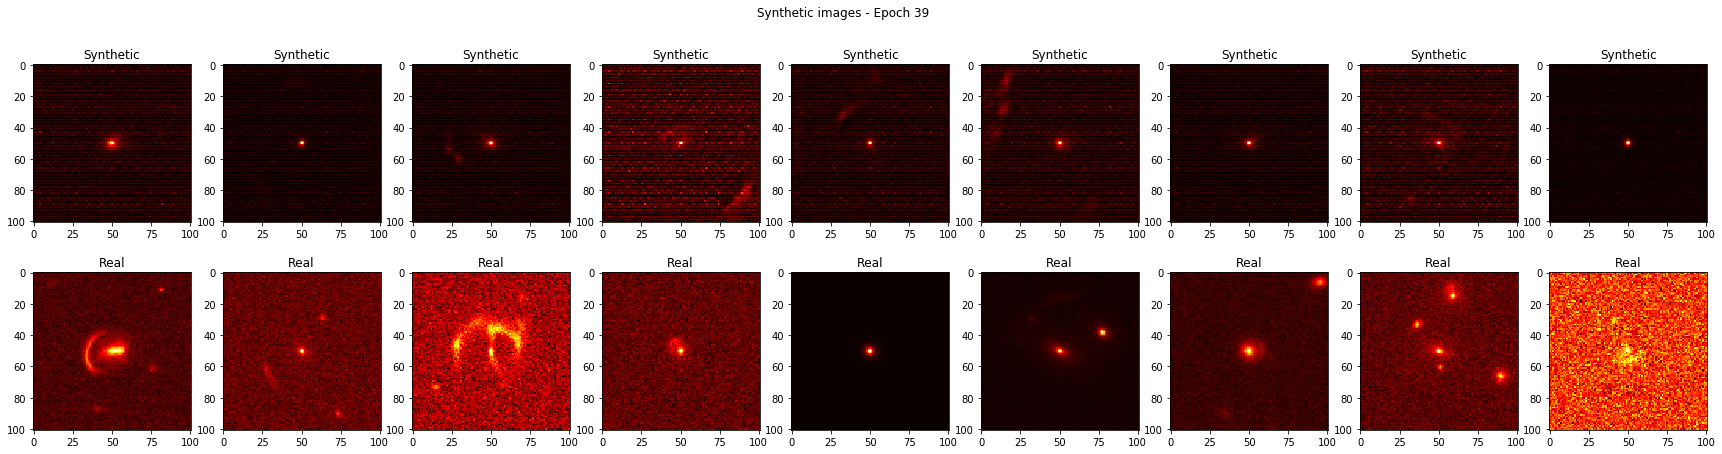



                    Loss Synthetic: 0.7081000208854675 - Loss Real: 0.7429999709129333 

                    Acc Synthetic: 0.4000000059604645 - Acc Real: 0.6000000238418579
                             Generator Acc: 0.06669999659061432
            

            Epoch: 41 - Discriminator loss:0.7255288362503052 - Discriminator Accuracy: 0.5 - Generator loss:1.4106059074401855
            




                    Loss Synthetic: 0.7723000049591064 - Loss Real: 0.8675000071525574 

                    Acc Synthetic: 0.53329998254776 - Acc Real: 0.13330000638961792
                             Generator Acc: 0.0
            

            Epoch: 42 - Discriminator loss:0.819909930229187 - Discriminator Accuracy: 0.3333333432674408 - Generator loss:1.2453783750534058
            




                    Loss Synthetic: 0.5112000107765198 - Loss Real: 1.0047999620437622 

                    Acc Synthetic: 0.8666999936103821 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.13330000638961792
            

            Epoch: 43 - Discriminator loss:0.7579758167266846 - Discriminator Accuracy: 0.5333333611488342 - Generator loss:1.172183632850647
            




                    Loss Synthetic: 0.5791000127792358 - Loss Real: 0.8968999981880188 

                    Acc Synthetic: 0.733299970626831 - Acc Real: 0.13330000638961792
                             Generator Acc: 0.13330000638961792
            

            Epoch: 44 - Discriminator loss:0.737985372543335 - Discriminator Accuracy: 0.4333333373069763 - Generator loss:1.0266108512878418
            




                    Loss Synthetic: 0.5945000052452087 - Loss Real: 0.7480999827384949 

                    Acc Synthetic: 0.800000011920929 - Acc Real: 0.4666999876499176
                             Generator Acc: 0.06669999659061432
            

            Epoch: 45 - Discriminator loss:0.6713067889213562 - Discriminator Accuracy: 0.6333333253860474 - Generator loss:1.2823246717453003
            


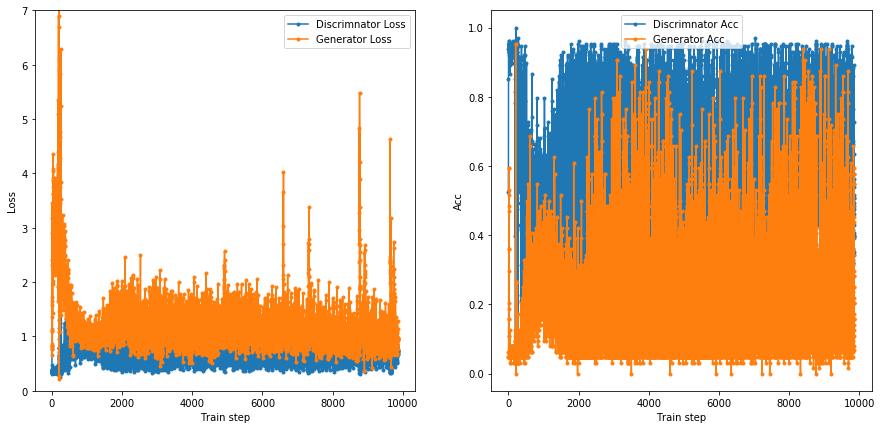

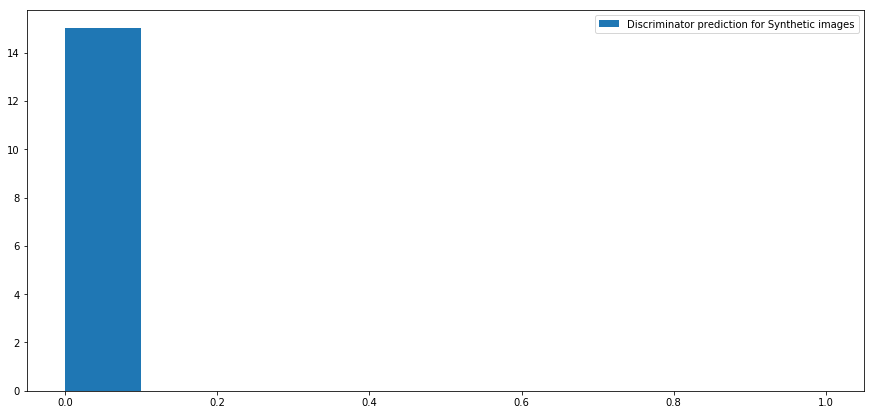

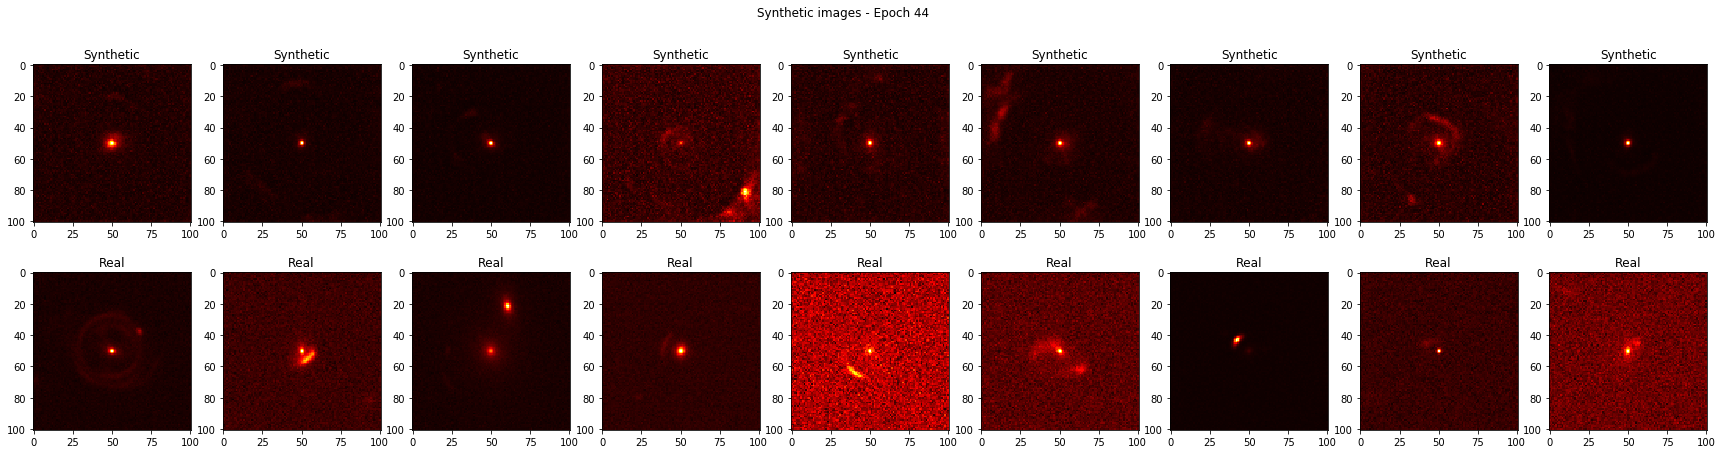



                    Loss Synthetic: 0.7897999882698059 - Loss Real: 0.880299985408783 

                    Acc Synthetic: 0.4000000059604645 - Acc Real: 0.20000000298023224
                             Generator Acc: 0.20000000298023224
            

            Epoch: 46 - Discriminator loss:0.83503258228302 - Discriminator Accuracy: 0.30000001192092896 - Generator loss:1.2991454601287842
            




                    Loss Synthetic: 0.579200029373169 - Loss Real: 0.8331999778747559 

                    Acc Synthetic: 0.800000011920929 - Acc Real: 0.33329999446868896
                             Generator Acc: 0.6000000238418579
            

            Epoch: 47 - Discriminator loss:0.7062424421310425 - Discriminator Accuracy: 0.5666666626930237 - Generator loss:0.7188588380813599
            




                    Loss Synthetic: 0.6693999767303467 - Loss Real: 0.7706000208854675 

                    Acc Synthetic: 0.4666999876499176 - Acc Real: 0.33329999446868896
                             Generator Acc: 0.20000000298023224
            

            Epoch: 48 - Discriminator loss:0.7199838757514954 - Discriminator Accuracy: 0.4000000059604645 - Generator loss:0.8392776250839233
            




                    Loss Synthetic: 0.5333999991416931 - Loss Real: 0.670199990272522 

                    Acc Synthetic: 0.8666999936103821 - Acc Real: 0.666700005531311
                             Generator Acc: 0.20000000298023224
            

            Epoch: 49 - Discriminator loss:0.6018233299255371 - Discriminator Accuracy: 0.7666666507720947 - Generator loss:1.0642443895339966
            




                    Loss Synthetic: 0.7211999893188477 - Loss Real: 0.65829998254776 

                    Acc Synthetic: 0.4000000059604645 - Acc Real: 0.53329998254776
                             Generator Acc: 0.0
            

            Epoch: 50 - Discriminator loss:0.6897261142730713 - Discriminator Accuracy: 0.46666669845581055 - Generator loss:1.1067684888839722
            


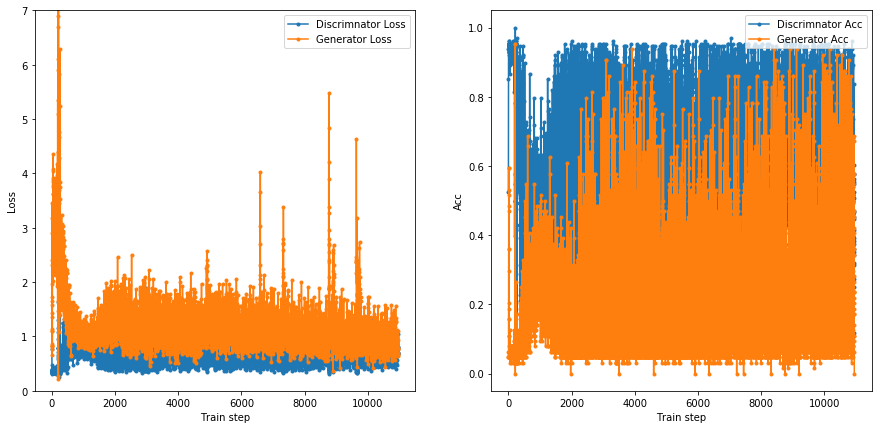

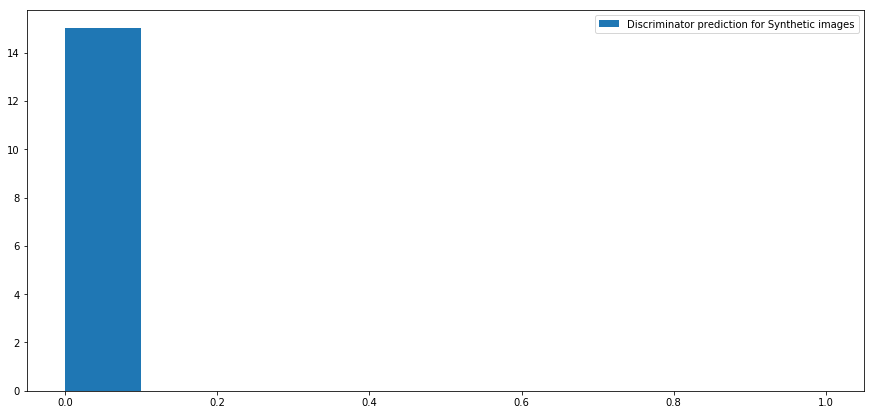

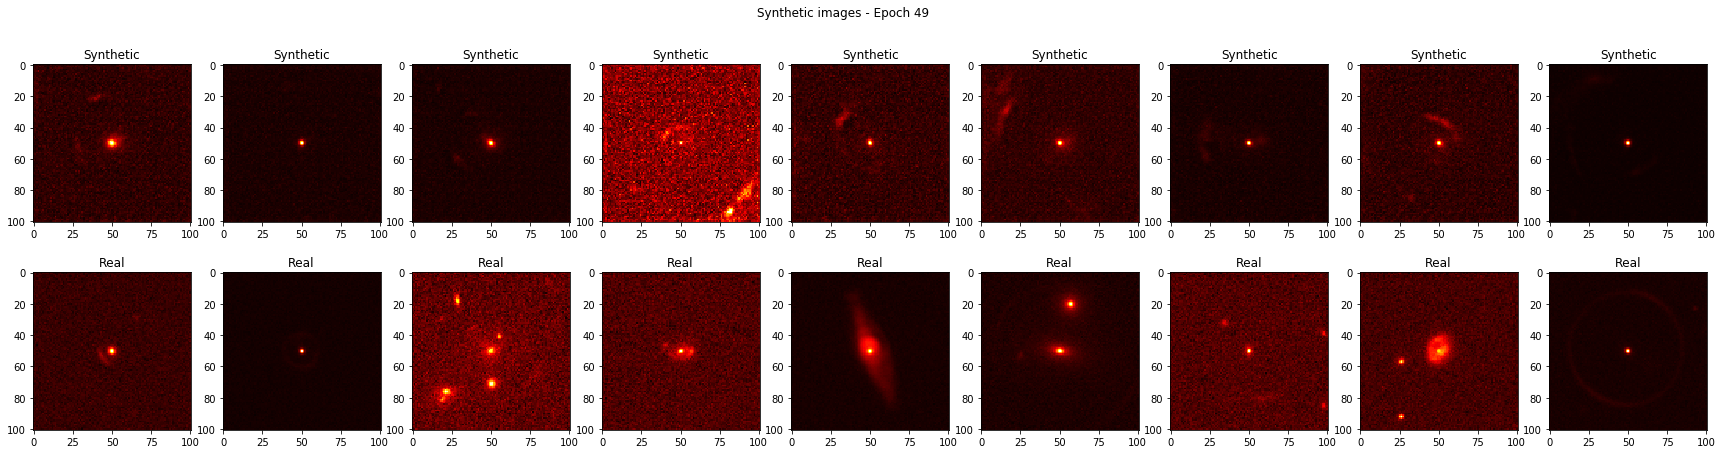

In [11]:
lens_images = lensgen.preprocess_images(lens_images)
lensgen.train(lens_images,64,50,d_steps=1,plot_images=True)

## Save losses and gen images

In [12]:
df_loss = pd.DataFrame({'d_loss':lensgen.d_loss,'g_loss':lensgen.g_loss})
df_loss.to_csv('../results/train/50_epochs_test.csv',sep=';',index=False)

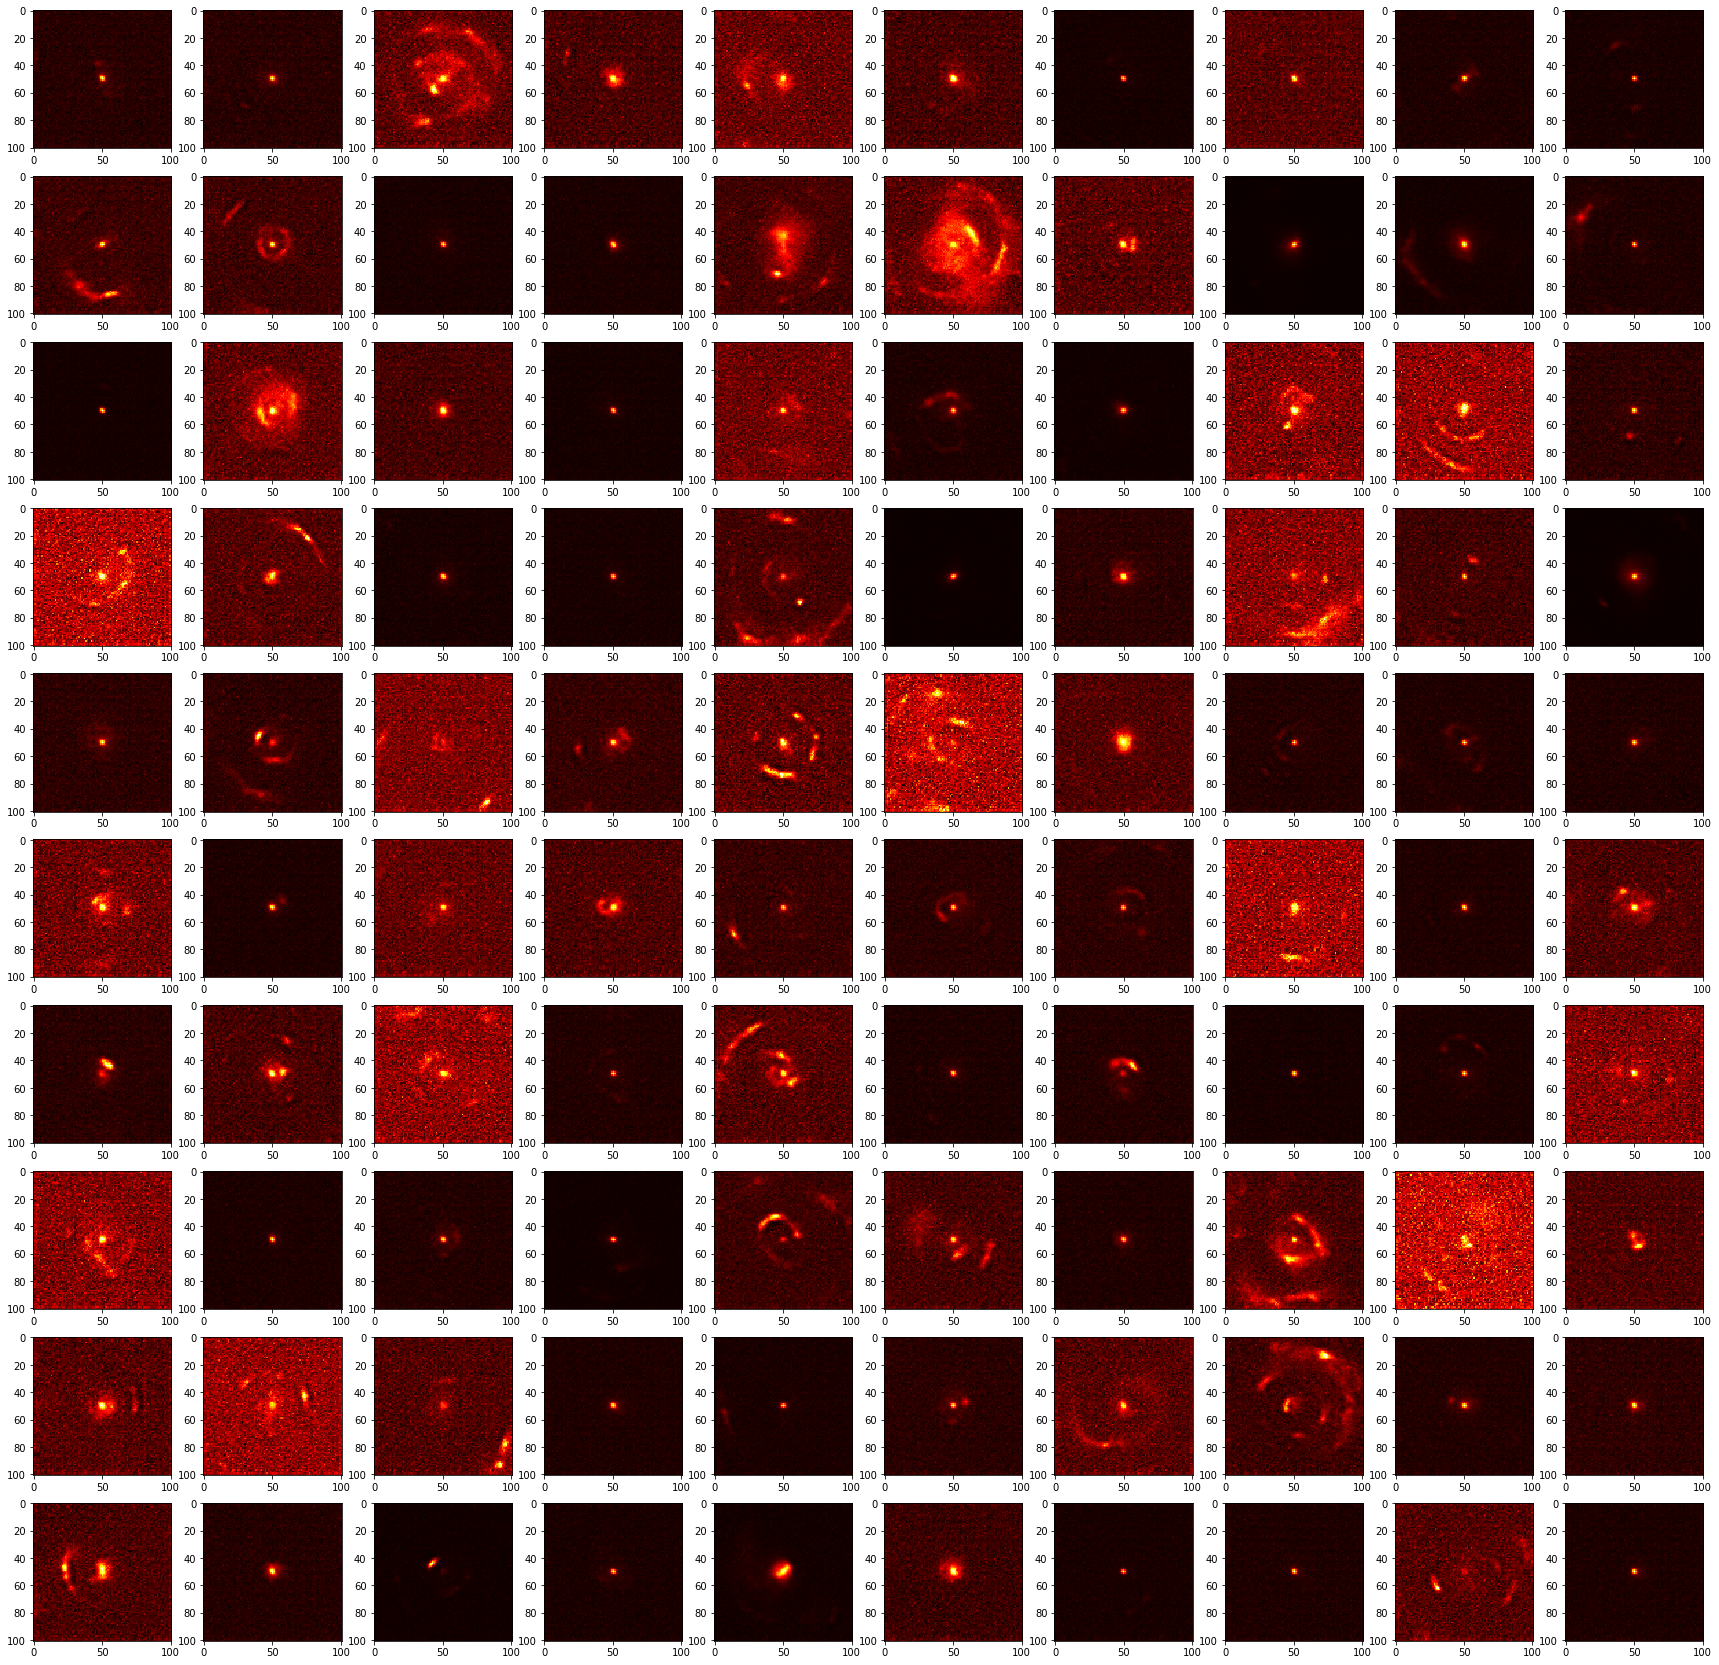

In [13]:
lensgen.save_images('../reports/figures/50_epochs_test.png')

## Save Model

In [15]:
lensgen.g_model.save('../models/50_epochs_test.h5')